In [11]:
import torch
import torch.optim as optim
import torch.nn as nn

In [12]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0] 
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] 

t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u

tensor([[35.7000],
        [55.9000],
        [58.2000],
        [81.9000],
        [56.3000],
        [48.9000],
        [33.9000],
        [21.8000],
        [48.4000],
        [60.4000],
        [68.4000]])

In [13]:
n_samples = t_u.shape[0] # number of samples
n_val = int(0.2 * n_samples) # the validation data is 20% of all data

shuffled_indices = torch.randperm(n_samples) # 0-10 scrambled

train_indices = shuffled_indices[:-n_val] # all but the last 20%
val_indices = shuffled_indices[-n_val:] # the last 20%


shuffled_indices, train_indices, val_indices

(tensor([ 2,  8,  3,  7,  5,  0,  6,  1,  4, 10,  9]),
 tensor([2, 8, 3, 7, 5, 0, 6, 1, 4]),
 tensor([10,  9]))

In [14]:
train_t_u = t_u[train_indices] # scrambled temp units
train_t_c = t_c[train_indices] # matching scrambled celcius measurements

# validation set

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u #normalized temp readings
val_t_un = 0.1 * val_t_u


In [15]:
from collections import OrderedDict


seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8,1))
]))

learning_rate = 1e-3
optimizer = optim.SGD(seq_model.parameters(), lr=learning_rate)

seq_model
    

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [20]:
class SubclassFunctionalModel(nn.Module):
    def __init__(self): 
        super().__init__()
        
        self.hidden_linear = nn.Linear(1, 14)
    
        self.output_linear = nn.Linear(14, 1)
    
    def forward(self, input):
        hidden_t = self.hidden_linear(input) 
        activated_t = torch.tanh(hidden_t) 
        output_t = self.output_linear(activated_t)
    
        return output_t

func_model = SubclassFunctionalModel() 
func_model

SubclassFunctionalModel(
  (hidden_linear): Linear(in_features=1, out_features=14, bias=True)
  (output_linear): Linear(in_features=14, out_features=1, bias=True)
)

## Down along the descent

To find the derivative of the weight in respect to the cost function we follow the chain rule. What's the derivitive of the of cost function in respect to temp predicted TIMES the derivitive of the temps predicted in respect to the weights. 

This gives us the gradient for each parameter (what's it needing to be changed by)? grad_fn( )

Each example's gradient is averaged to nudge the parameter,

In [16]:
def training_loop(n_epochs, optimizer, model, cost_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    
    for epoch in range(1, n_epochs + 1):
        
        t_p_train = model(t_u_train) # forward pass
        cost_train = cost_fn(t_p_train, t_c_train) # how did the forward pass do?
        
        
        t_p_val = model(t_u_val)
        cost_val = cost_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad() # clear gradients from last descent, weights and biases have already been changed with that data
        
        cost_train.backward() # find gradients of weights & biases with respect to the cost again now that that they are updated
        
        # find the derivitives cost function with respect to each
        # parameter, then add the difference of the gradient in proportion with the learning_rate

        optimizer.step()
        
        if epoch == 1 or epoch % 1000 == 0:
            print('Epoch {}, Training Cost {}, Validation Cost {}'.format(epoch, float(cost_train), float(cost_val)))

In [17]:
training_loop(
n_epochs = 3000,
optimizer=optimizer,    
model = seq_model,
cost_fn = nn.MSELoss(), 
t_u_train = train_t_un,
t_u_val = val_t_un,
t_c_train = train_t_c,
t_c_val = val_t_c)

Epoch 1, Training Cost 155.19061279296875, Validation Cost 293.6072998046875
Epoch 1000, Training Cost 5.939525127410889, Validation Cost 5.0084381103515625
Epoch 2000, Training Cost 3.0230753421783447, Validation Cost 2.2840046882629395
Epoch 3000, Training Cost 2.14674973487854, Validation Cost 1.8551634550094604


### This netowrk had roughly a 2.15 cost on the training data and a 1.86 cost on the validation data.

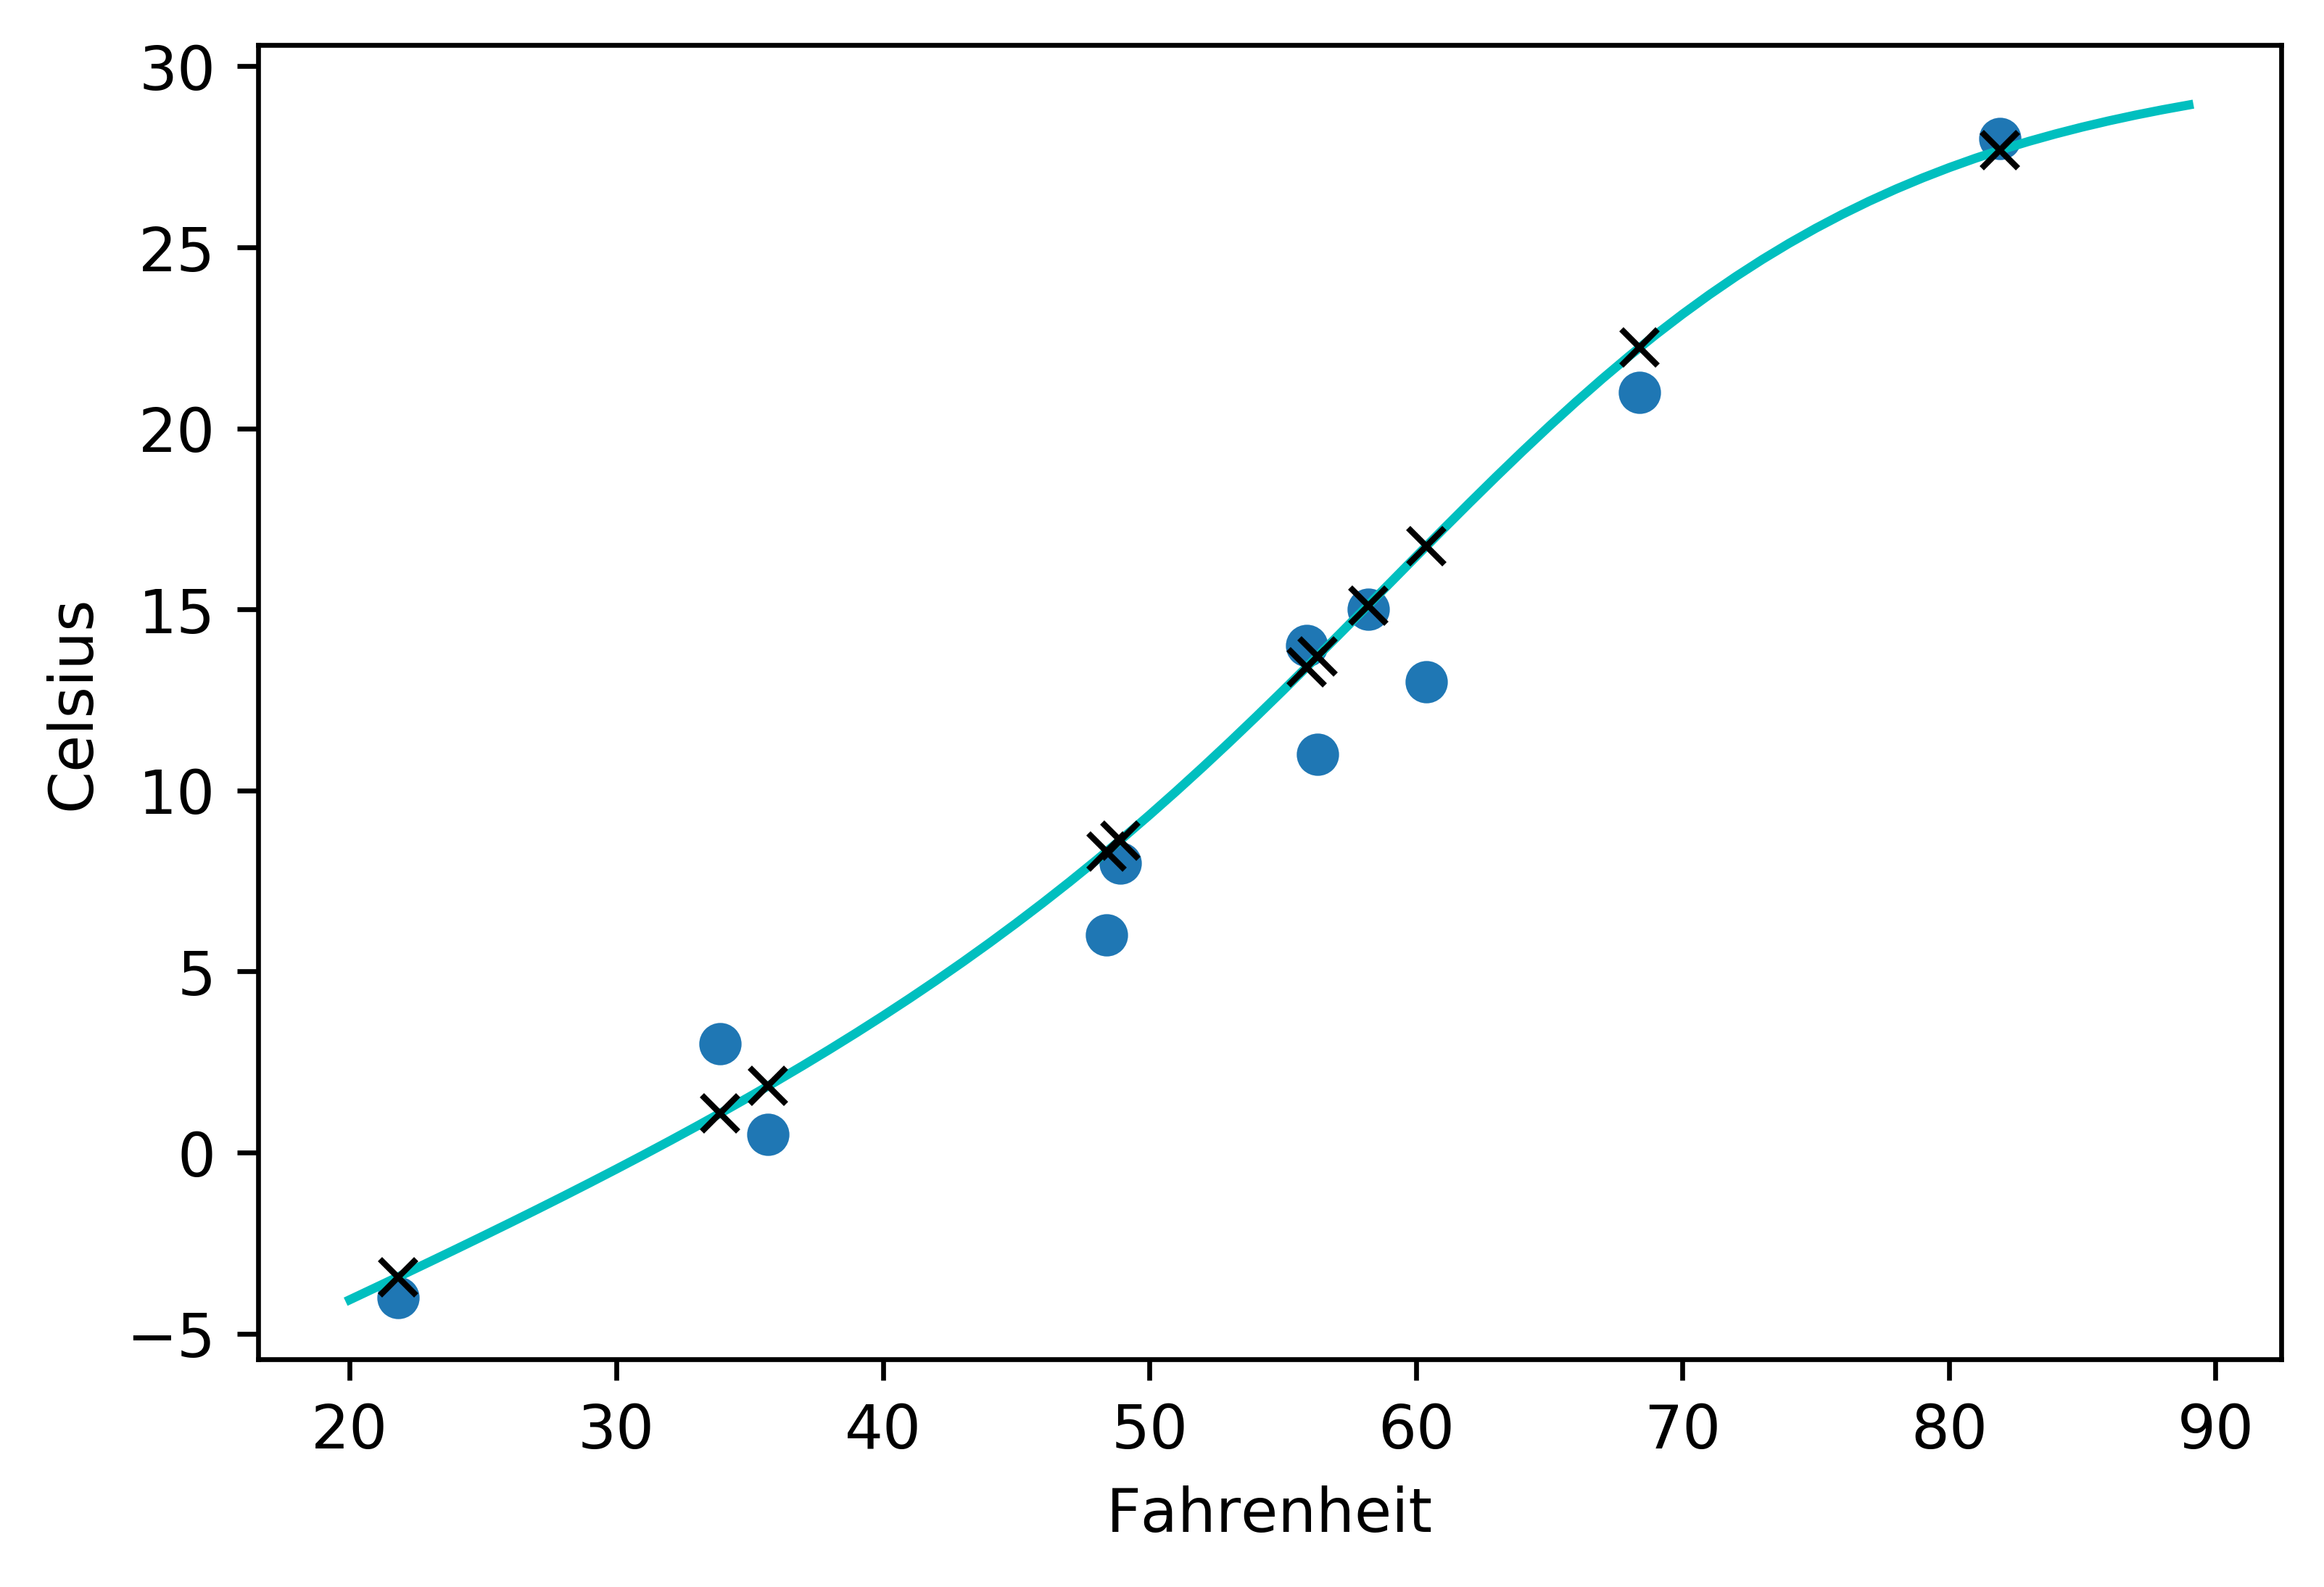

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt
t_range = torch.arange(20.,90.).unsqueeze(1)


fig = plt.figure(dpi=600) 
plt.xlabel("Fahrenheit") 
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-') 
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

In [25]:
# The blue line is essentially the brain here.